In [0]:
#import libraries
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
np.random.seed(1)

In [0]:
#helper Functions
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches
  
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

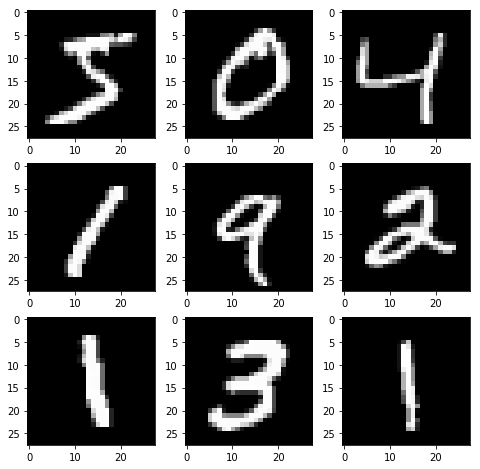

In [21]:
#display samples of the train dataset
import matplotlib.pyplot as plt
%matplotlib inline 
image_index = -1 
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(x_train[image_index+i],cmap='gray')
    

In [22]:
#preprocess the datasets
X_train = x_train/255.
X_test = x_test/255.

#convert the labels into one_hot representation
Y_train = convert_to_one_hot(y_train, 10)
Y_test = convert_to_one_hot(y_test, 10)

#reshape the dataset - so the network knows it's an image
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

#check the shape of the dataset
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


number of training examples = 60000
number of test examples = 10000
X_train shape: (60000, 28, 28, 1)
Y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
Y_test shape: (10000, 10)


In [0]:
#Function to create placeholders for X and Y 
def create_placeholders(n_H0, n_W0, n_C0, n_y):

    X = tf.placeholder(tf.float32,shape=(None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(tf.float32,shape=(None,n_y))
    
    return X, Y
  
#Function to initialize parameters
def initialize_parameters():
    
    tf.set_random_seed(1)      

    W1 = tf.get_variable("W1", [8, 8, 1, 8], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [4, 4, 8, 16], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))
    W3 = tf.get_variable("W3", [2, 2, 16, 32], initializer =  tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2,
                  "W3": W3}
    
    return parameters
  
  
#Function to create the forward propogation (layers are added in this function)
def forward_propagation(X, parameters):
    
    #initialize weights of the conv filters
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']

    
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')

    A1 = tf.nn.relu(Z1)

    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')

    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')

    A2 = tf.nn.relu(Z2)

    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    
    Z3 = tf.nn.conv2d(P2,W3, strides = [1,1,1,1], padding = 'SAME')

    A3 = tf.nn.relu(Z3)

    P3 = tf.nn.max_pool(A3, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'SAME')

    P3 = tf.layers.flatten(A3)
    
    #the output layer
    Z4 = tf.contrib.layers.fully_connected(P3, 10, activation_fn=None)

    return Z4
  
  
#Function to create the model, and define hyperparameters
def model(X_train, Y_train, X_test, Y_test, optimizer='adam', learning_rate = 0.001,
          num_epochs = 150, minibatch_size = 64, print_cost = True):
    
    
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, H, W, C) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        
    

    X, Y = create_placeholders(H, W, C, n_y)


    parameters = initialize_parameters()

    
    Z = forward_propagation(X, parameters)
    

    cost =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y))

    
    if optimizer=='adagrad':
        optimizer = tf.train.AdagradOptimizer(learning_rate = learning_rate).minimize(cost)
    elif optimizer=='adagradda':
        optimizer = tf.train.AdagradDAOptimizer(learning_rate = learning_rate).minimize(cost)
    elif optimizer=='adadelta':
        optimizer = tf.train.AdadeltaOptimizer(learning_rate = learning_rate).minimize(cost)
    elif optimizer=='adam':
        optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

        
    init = tf.global_variables_initializer()
     

    with tf.Session() as sess:

        sess.run(init)
        #mini batch train 
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) 
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        #plot the cost over epochs
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z, 1), tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 0.612073
Cost after epoch 5: 0.099441
Cost after epoch 10: 0.073109
Cost after epoch 15: 0.060353
Cost after epoch 20: 0.054840
Cost after epoch 25: 0.049156
Cost after epoch 30: 0.044039
Cost after epoch 35: 0.041220
Cost after epoch 40: 0.038202
Cost after epoch 45: 0.035070
Cost after epoch 50: 0.032667
Cost after epoch 55: 0.031406
Cost after epoch 60: 0.030

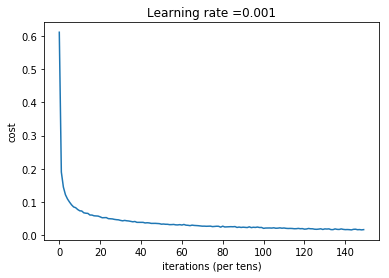

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.9924333
Test Accuracy: 0.9804


In [24]:
train_accuracy, text_accuracy, parameters = model(X_train, Y_train, X_test, Y_test)